In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [93]:
Data = pd.ExcelFile('Data_raw (2).xlsx').parse('data_m')

In [94]:
Data.head()

,Date,K200,CD3m,CD1m,Call1d,USDKRW,USDLIBOR3m,USDLIBOR1m
0,1990-01-31,97.83,15.0,14.0,13.0,686.3,8.3750,8.3125
1,1990-02-28,94.06,15.0,14.0,13.0,694.0,8.3750,8.3750
2,1990-03-31,92.10,15.0,14.0,13.0,702.1,8.5000,8.3750
3,1990-04-30,74.93,15.0,14.0,13.0,707.0,8.6875,8.5000
4,1990-05-31,87.67,15.0,14.0,13.0,712.3,8.3750,8.3125


In [99]:
#날짜 기준으로 오름차순 정렬된 Data 불러오기
rawTime = Data.iloc[:,0].copy()
rawK200 = Data.iloc[:,1].copy()
rawUSD = Data.iloc[:,5].copy() 
rawUSDL1m = Data.iloc[:,7].copy()

In [100]:
#C/G HPR(%, in KRW)
rawCR1 = (rawK200/rawK200.shift(1)-1)*100 
rawCR2 = (rawUSD/rawUSD.shift(1)-1)*100

In [101]:
#I/G HPR(%, in KRW)
rawIR1 = 0
rawIR2_USD = rawUSDL1m/12
rawIR2 = ((1+ rawIR2_USD/100)*(1+rawCR2/100)-1)*100 #원화로 환산

In [102]:
rawR1 = rawCR1 + rawIR1
rawR2 = rawCR2 + rawIR2

In [103]:
#Risk-parity 전략의 가중치
tau = 12
rawSig1 = rawR1.rolling(tau).std() #K200의 최근 표준편차
rawSig2 = rawR2.rolling(tau).std() #USD의 최근 표준편차
rawW1 = rawSig2/(rawSig1 + rawSig2)
rawW2 = 1 -rawW1

In [104]:
rawR1[1:12].std()

10.405871030212419

In [105]:
#Back Test
stdatenum = 19941228 #백테스트 시작일
stdate = pd.to_datetime(str(stdatenum), format= '%Y%m%d')
idx = np.argmin(np.abs(rawTime- stdate)) #백테스트 시작일에 해당하는 index

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


In [106]:
#Back Test 시작일 이후 데이터만 정리
Time = rawTime[idx:].copy().reset_index(drop = True) #index 초기화하는거
numData = Time.shape[0]

In [107]:
R1 = rawR1[idx:].copy().reset_index(drop = True)
R2 = rawR2[idx:].copy().reset_index(drop = True)
W1 = rawW1[idx:].copy().reset_index(drop = True)
W2 = rawW2[idx:].copy().reset_index(drop = True)

In [108]:
#Portfolio value 시계열 연산

#Fixed weight(5:5)
Rp_FixedW = 0.5*R1 + 0.5*R2
Vp_FixedW = pd.Series(np.zeros(numData)) #value
Vp_FixedW[0] = 100  # 투자원금 = 100
for t in range( 1, numData):
    Vp_FixedW[t] = Vp_FixedW[t-1]*(1+Rp_FixedW[t]/100)

In [109]:
#Risk parity
Rp_RiskP = pd.Series(np.zeros(numData)) #수익률
Vp_RiskP = pd.Series(np.zeros(numData)) # value
Vp_RiskP[0] = 100 #초기원금
for t in range (1, numData):
    Rp_RiskP[t] = W1[t-1]*R1[t] + W2[t-1]*R2[t]
    Vp_RiskP[t] = Vp_RiskP[t-1]*(1+ Rp_RiskP[t]/100)

In [110]:
#성과비교 : Value, MDD 시계열
#fixed weight
Vmax_FixedW = Vp_FixedW.cummax()
MDD_FixedW = (Vp_FixedW-Vmax_FixedW-1)*100

#risk-parity
Vmax_RiskP = Rp_FixedW.cummax()
MDD_RiskP = (Rp_FixedW-Vmax_RiskP-1)*100

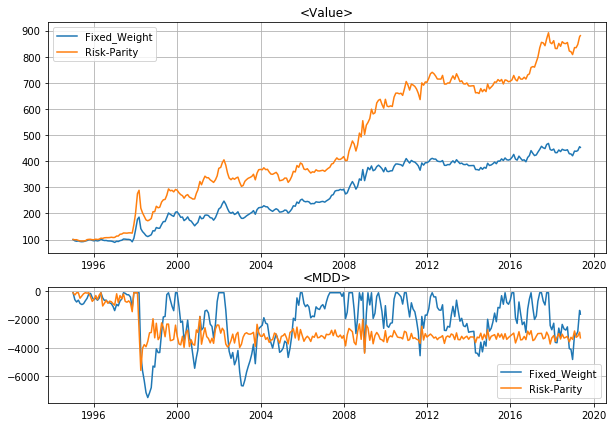

In [111]:
#그래프 그리기
fig = plt.figure(figsize = (10,7))
gs = gridspec.GridSpec(nrows=2,
                       ncols =1,
                       height_ratios= [8,4],
                       width_ratios= [5]) #subplot의 크기를 서로 다르게 설정

#Value
ax0 = plt.subplot(gs[0])
ax0.plot(Time, Vp_FixedW , label = 'Fixed_Weight');
ax0.plot(Time, Vp_RiskP, label = 'Risk-Parity');
plt.title('<Value>')
ax0.grid(True)
ax0.legend()

#MDD
ax1 = plt.subplot(gs[1])
ax1.plot(Time, MDD_FixedW, label = 'Fixed_Weight');
ax1.plot(Time, MDD_RiskP, label = 'Risk-Parity');
plt.title('<MDD>')
ax1.grid(True)
ax1.legend()